In [1]:
from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean
import copy

import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights 

In [14]:
human_result_path=r"..\data\test.xlsx"
human_result = pd.read_excel(human_result_path)
human_result_1a=human_result[human_result["Experiment"]=="1a"]


In [15]:
arpabet_to_ipa = {
    'W': 'w',
    'UW0': 'u',
    'N': 'n',
    'AW1': 'aʊ',
    'OW0': 'oʊ',
    'IY0': 'i',
    'L': 'l',
    'IY1': 'i',
    'SH': 'ʃ',
    'AE2': 'æ',
    'AO1': 'ɒ',
    'HH': 'h',
    'V': 'v',
    'AA2': 'ɑ',
    'EY2': 'eɪ',
    'AE1': 'æ',
    'Z': 'z',
    'UW2': 'u',
    'D': 'd',
    'AH2': 'ʌ',
    'M': 'm',
    'B': 'b',
    'IY2': 'i',
    'OY1': 'ɔɪ',
    'F': 'f',
    'CH': 'tʃ',
    'Y': 'j',
    'TH': 'θ',
    'ER1': 'ɜ',
    'ER0': 'ɜ',
    'AO2': 'ɒ',
    'JH': 'dʒ',
    'UW1': 'u',
    'P': 'p',
    'AY1': 'aɪ',
    'IH2': 'ɪ',
    'T': 't',
    'K': 'k',
    'AO0': 'ɒ',
    'DH': 'ð',
    'OW2': 'oʊ',
    'EH1': 'e',
    'G': 'ɡ',
    'IH0': 'ɪ',
    'AH1': 'ʌ',
    'EY1': 'eɪ',
    'AH0': 'ʌ',
    'NG': 'ŋ',
    'AA1': 'ɑ',
    'IH1': 'ɪ',
    'S': 's',
    'OW1': 'oʊ',
    'UH1': 'ʊ',
    'R': 'ɹ'
}

In [105]:
def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]

def CTC_index(processor,outind):
    meaningful_ids = []
    meaningful_indices = []
    previous_id = -1  
    blank_token_id = processor.tokenizer.pad_token_id  
    for i, token_id in enumerate(outind[0]):  
        if token_id != previous_id and token_id != blank_token_id:
            meaningful_ids.append(token_id.item())  
            meaningful_indices.append(i)  
        previous_id = token_id
    
    return meaningful_indices

def get_set_diphone(paths,model,processor):
    out_dict={}
    english_phonemes = ['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    #english_phoneme_dict.values()
    for each_sentence in paths:
        tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
        tg_sentence = [i for i in tg[0] if i.mark!=""]
        wave, sr = librosa.load(each_sentence)
        wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
        #wave_res = wave_res[:int(sentence16_end_time*16000)]
        for each_tg in tg_sentence:
            start=round(each_tg.minTime*16000)
            end=round(each_tg.maxTime*16000)
            input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
            input=input.to(device)
            model.to(device)
            with torch.no_grad():
                out_encoder1=model(input).logits
            selected=out_encoder1
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            transcription = processor.batch_decode(outind)[0].split(" ")
            phonemeindex = CTC_index(processor,outind)
            out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().detach().numpy()
            for i in range(len(transcription)-1):
                key = transcription[i] + transcription[i + 1]
                if key not in out_dict:
                    out_dict[key] = []
                out_dict[key].append(np.vstack((out_FE[phonemeindex[i]], out_FE[phonemeindex[i + 1]])))
            torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return out_dict


def get_training_paths(TrainingTalkerID,all_path):
    path_list=[]
    TalkerID=[]
    for each_ID in TrainingTalkerID.split(", "):
        if each_ID[:3]=="CMN":
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_CMN_ENG_HT1")
        else:
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_ENG_ENG_HT1")
    
    for each_path in TalkerID:
        for i in all_path:
            if each_path in i:
                path_list.append(i)
                break
    
    return path_list
def align_sequences(seq1, seq2):
    len1, len2 = len(seq1), len(seq2)
    dp = np.zeros((len1 + 1, len2 + 1), dtype=int)

    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j

    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,   
                           dp[i][j - 1] + 1,   
                           dp[i - 1][j - 1] + cost)       
    aligned_seq1, aligned_seq2 = [], []
    i, j = len1, len2
    while i > 0 or j > 0:
        if i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append('<pad>')  
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + 1:
            aligned_seq1.append('<pad>')
            aligned_seq2.append(seq2[j - 1])
            j -= 1
        else:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append(seq2[j - 1])
            i -= 1
            j -= 1
    return aligned_seq1[::-1], aligned_seq2[::-1]



def build_exposure_set(paths, native_dict, set_list, model,processor):
    english_phonemes = ['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    english_phoneme_dict.values()
    for each_sentence in paths:
        tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
        tg_sentence = [i for i in tg[0] if i.mark!=""]
        tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
        tg_sentence = [each for _,each in enumerate(tg_sentence) if _ in set_list]
        '''sentence16_end_time=tg_sentence[15].maxTime
        tg_sentence = [i for i in tg_sentence if i.maxTime<=sentence16_end_time]
        tg_word = [i for i in tg_word if i.maxTime<=sentence16_end_time]'''
        
        wave, sr = librosa.load(each_sentence)
        wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
        #wave_res = wave_res[:int(sentence16_end_time*16000)]
        for each_tg in tg_sentence:
            start=round(each_tg.minTime*16000)
            end=round(each_tg.maxTime*16000)
            input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
            input=input.to(device)
            model.to(device)
            with torch.no_grad():
                out_encoder1=model(input).logits
            selected=out_encoder1
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            #outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
            transcription = processor.batch_decode(outind)[0].split(" ")
            phonemeindex = CTC_index(processor,outind)
            out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().detach().numpy()
            for i in range(len(transcription)-1):
                key = transcription[i] + transcription[i + 1]
                if key not in native_dict:
                    native_dict[key] = []
                native_dict[key].append(np.vstack((out_FE[phonemeindex[i]], out_FE[phonemeindex[i + 1]])))
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return native_dict
    #'..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_032_M_CMN_ENG_HT1.wav'
def get_test_list(file_path,key_word,sentenceID,model,processor):
    english_phonemes = ['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    sentenceID=int(sentenceID[-3:])-1
    #file_path= f'..\\data\\raw\\ALL_CMN_ENG_HT1\\{file_path[:-5]}.wav'
    
    tg = textgrid.TextGrid.fromFile(file_path[:-3]+"TextGrid")
    tg_sentence = [i for i in tg[0] if i.mark!=""][sentenceID]
    
    tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
    
    wave, sr = librosa.load(file_path)
    wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
    

    for each_word_tg in tg_word:
        if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
            #print(each_word_tg.mark.lower(),key_word)
            if each_word_tg.mark.lower()==key_word:
                start=each_word_tg.minTime
                end=each_word_tg.maxTime
                break
                #print("start:",start,"end:",end)
    #word_length=len(wave_res)/16000
    out_list=[]
    
    sentence_total_length=tg_sentence.maxTime-tg_sentence.minTime
    word_cut_start=start-tg_sentence.minTime
    word_cut_end=end-tg_sentence.minTime
    
    input=processor(wave_res[int(tg_sentence.minTime*16000):round(tg_sentence.maxTime*16000)], sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        out_encoder=model(input.to(device)).logits
        out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().numpy()
    
    word_start=round(out_encoder.shape[1]*word_cut_start/sentence_total_length)
    word_end=round(out_encoder.shape[1]*word_cut_end/sentence_total_length)
    
    selected=out_encoder[:,word_start:word_end,:]
    mask = np.ones(selected.shape[-1], dtype=bool)
    mask[list(english_phoneme_dict.values())] = False
    selected[:, :, mask] = 0
    outind=torch.argmax(selected,dim=-1).cpu().numpy()
    phonemeindex = CTC_index(processor,outind)
    transcription = processor_P.batch_decode(outind)[0].split(" ")
    
    
    if len(phonemeindex)<2:
        each_FE = out_FE[word_start:,:]
        selected=out_encoder[:,word_start:,:]
        mask = np.ones(selected.shape[-1], dtype=bool)
        mask[list(english_phoneme_dict.values())] = False
        selected[:, :, mask] = 0
        outind=torch.argmax(selected,dim=-1).cpu().numpy()
        phonemeindex = CTC_index(processor,outind)
        transcription = processor_P.batch_decode(outind)[0].split(" ")
        
        diphone_key = transcription[0] + transcription[0 + 1]
        out_list.append((diphone_key, np.vstack((each_FE[phonemeindex[0]], each_FE[phonemeindex[0 + 1]]))))

    else:
        each_FE = out_FE[word_start:word_end,:]
        for i in range(len(transcription)-1):
            diphone_key = transcription[i] + transcription[i + 1]
            out_list.append((diphone_key, np.vstack((each_FE[phonemeindex[i]], each_FE[phonemeindex[i + 1]]))))
    torch.cuda.empty_cache()
    return out_list


In [16]:
ALL_ENG_ENG_path=r"..\data\raw_L1"
ALL_ENG_ENG_pathset=get_pathset(ALL_ENG_ENG_path)
ALL_ENG_ENG_dict = get_set_diphone(ALL_ENG_ENG_pathset, model_P, processor_P)

In [117]:
def sim_measure(df,all_eng_dict, model, processor):
    sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count =[], [], [], [], []
    confusion_matrix_list, wav2vec_acc_list=[],[]
    X_list=[]
    Y_list=[]
    english_phonemes = ['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    
    phoneme_vocab = {phoneme: idx for idx, phoneme in enumerate(english_phonemes)}
    train_set_dict={}
    test_word_dict={}
    test_matrix_dict={}
    for each_ in tqdm.tqdm(df.values):
        filename_loc=df.columns.get_loc("Filename")
        keyword_loc=df.columns.get_loc("Keyword")
        training_talker_loc=df.columns.get_loc("TrainingTalkerID")
        
        all_path=get_pathset(r"..\data\raw")
        all_ENG_ENG_pathset=[s.replace("raw_L1", "raw") for s in get_pathset(r"..\data\raw_L1")]
        
        set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
        set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]
        if each_[df.columns.get_loc("TrainingTestSet")] == "set2,set1":
            train_set=set2_list
            test_set=set1_list
        else:
            train_set=set1_list
            test_set=set2_list
        
        #print(each_[filename_loc])
        test_file = [each for each in all_path if os.path.split(each_[filename_loc])[-1][:-5] in each]
        #print(test_file)
        key_word = each_[keyword_loc] #string
        TrainingTalkerID = each_[training_talker_loc] #list of string
        sentenceID = each_[df.columns.get_loc("SentenceID")]
        training_files_path=get_training_paths(TrainingTalkerID,all_path)
        
        if training_files_path[0] in all_ENG_ENG_pathset:
            training_dict=copy.deepcopy(all_eng_dict)
        else:
            if TrainingTalkerID not in train_set_dict:
                train_set_dict[TrainingTalkerID]={}
                
            if each_[df.columns.get_loc("TrainingTestSet")] not in train_set_dict[TrainingTalkerID]:
                training_dict=build_exposure_set(training_files_path, copy.deepcopy(all_eng_dict), train_set, model, processor)
                train_set_dict[TrainingTalkerID][each_[df.columns.get_loc("TrainingTestSet")]]=copy.deepcopy(training_dict)
            else:
                training_dict=train_set_dict[TrainingTalkerID][each_[df.columns.get_loc("TrainingTestSet")]]

        
        
        if test_file[0] not in test_word_dict:
            test_word_dict[test_file[0]]={}
        if sentenceID not in test_word_dict[test_file[0]]:
            test_word_dict[test_file[0]][sentenceID]={}
        if key_word not in test_word_dict[test_file[0]][sentenceID]:
            test_list = get_test_list(test_file[0], key_word, sentenceID, model, processor)
            test_word_dict[test_file[0]][sentenceID][key_word]=copy.deepcopy(test_list)
        else:
            test_list=test_word_dict[test_file[0]][sentenceID][key_word]
        
        if test_file[0] not in test_matrix_dict:
            test_matrix_dict[test_file[0]]={}
        if sentenceID not in test_matrix_dict[test_file[0]]:
            test_matrix_dict[test_file[0]][sentenceID]={}
        if key_word not in test_matrix_dict[test_file[0]][sentenceID]:
            
            tg = textgrid.TextGrid.fromFile(test_file[0][:-3]+"TextGrid")
            tg_sentence = [i for i in tg[0] if i.mark!=""][int(sentenceID[-3:])-1]
            tg_word = [i for i in tg[1] if tg_sentence.minTime<=i.minTime and tg_sentence.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark.lower()==key_word][0]
            
            each_word_phonemes =[arpabet_to_ipa[i.mark] for i in tg[-1] if tg_word.minTime<=i.minTime and tg_word.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp"]
            
            sentence_total_length=tg_sentence.maxTime-tg_sentence.minTime
            word_cut_start=tg_word.minTime-tg_sentence.minTime
            word_cut_end=tg_word.maxTime-tg_sentence.minTime
            wave, sr = librosa.load(test_file[0])
            wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
            input=processor(wave_res[int(tg_sentence.minTime*16000):round(tg_sentence.maxTime*16000)], sampling_rate=16000, return_tensors="pt").input_values.to(device)
            with torch.no_grad():
                out_encoder=model(input.to(device)).logits
                
            word_start=round(out_encoder.shape[1]*word_cut_start/sentence_total_length)
            word_end=round(out_encoder.shape[1]*word_cut_end/sentence_total_length)
            selected=out_encoder[:,word_start:word_end,:]
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            #phonemeindex = CTC_index(processor,outind)
            transcription = processor_P.batch_decode(outind)[0].split(" ")
            X_=each_word_phonemes
            Y_=transcription
            #print(each_word_phonemes,"\n",transcription)
            aligned_seq1, aligned_seq2 = align_sequences(each_word_phonemes,transcription)
            
            N=len(list(phoneme_vocab.keys()))
            confusion_matrix = np.zeros((N, N), dtype=int)
            #print(confusion_matrix.shape)
            for true_phoneme, predicted_phoneme in zip(aligned_seq1, aligned_seq2):
                true_idx = phoneme_vocab[true_phoneme]
                predicted_idx = phoneme_vocab[predicted_phoneme]
                #print(true_idx, predicted_idx)
                confusion_matrix[true_idx, predicted_idx] += 1
            
            phoneme_error = [1 if aligned_seq1[_]==aligned_seq2[_] else 0 for _ in range(len(aligned_seq1))]
            #print(np.array(list(english_phoneme_dict.values())))
            #confusion_matrix = #out_encoder[:,word_start:word_end,list(english_phoneme_dict.values())].cpu().numpy()
            test_matrix_dict[test_file[0]][sentenceID][key_word]=(X_,Y_,phoneme_error, confusion_matrix)
        else:
            X_=test_matrix_dict[test_file[0]][sentenceID][key_word][0]
            Y_=test_matrix_dict[test_file[0]][sentenceID][key_word][1]
            phoneme_error = test_matrix_dict[test_file[0]][sentenceID][key_word][2]
            confusion_matrix = test_matrix_dict[test_file[0]][sentenceID][key_word][3]
        
        # word level, list
        sim_max=[]
        sim_std=[]
        sim_mean=[]
        isincluded=[]
        #sim_count=[]
        for _, each_diphone in enumerate(test_list):
            
            sims=[]
            if each_diphone[0] in training_dict.keys():
                if phoneme_error[_]==1 and phoneme_error[_+1]==1:
                    isincluded.append(1)
                    
                    for each_vec in training_dict[each_diphone[0]]:
                        d=euclidean(each_diphone[1].ravel(),each_vec.ravel())
                        sim=np.exp(-0.1*d)
                        sims.append(sim)
                        #sims.append(0)
                else:
                    isincluded.append(1)
                    sims.append(0)
            else:
                isincluded.append(0)
                sims.append(0)
            #sim_count.append(len(sim))
            sim_max.append(np.max(sims))
            sim_std.append(np.std(sims))
            sim_mean.append(np.mean(sims))
            
            
        sim_mean_max=np.mean(sim_max)
        sim_mean_std=np.mean(sim_std)
        sim_mean_mean=np.mean(sim_mean)
        
        X_list.append(X_)
        Y_list.append(Y_)
        wav2vec_acc_list.append(np.count_nonzero(phoneme_error)/len(phoneme_error))
        confusion_matrix_list.append(confusion_matrix)
        sim_mean_max_list.append(sim_mean_max)
        sim_mean_std_list.append(sim_mean_std)
        sim_mean_mean_list.append(sim_mean_mean)
        isincluded_list.append(np.count_nonzero(isincluded))
        diphone_count.append(len(isincluded))
        
    return sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count,X_list,Y_list,wav2vec_acc_list, confusion_matrix_list



In [37]:
english_phonemes = ['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
np.array(list(english_phoneme_dict.values()),dtype=np.int64)

array([  1,   0,   2,   3,   4,   5,   6,   8,  10,  11,  12,  13,  16,
        17,  18,  21,  22,  23,  24,  25,  26,  27,  29,  32,  33,  34,
        35,  36,  37,  38,  39,  42,  44,  49,  52,  53,  58,  59,  60,
        66, 100, 170], dtype=int64)

In [77]:
path_raw=r"..\data\raw\ALL_ENG_ENG_HT1\ALL_133_M_ENG_ENG_HT1.wav"
tg = textgrid.TextGrid.fromFile(path_raw[:-3]+"TextGrid")
tg_sentence = [i for i in tg[0] if i.mark!=""][12]
tg_word = [i for i in tg[1] if tg_sentence.minTime<=i.minTime and tg_sentence.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark.lower()=="fish"][0]
for i in tg[-1]:
    if tg_word.minTime<=i.minTime and tg_word.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp":
        print(arpabet_to_ipa[i.mark])
#each_word_phonemes =[arpabet_to_ipa[i.mark] ]

f
ɪ
ʃ


In [75]:
tg[-1]

IntervalTier(Speaker - phone, [Interval(-0.0, 0.013, sp), Interval(0.013, 0.033, sp), Interval(0.033, 0.113, AH0), Interval(0.113, 0.243, B), Interval(0.243, 0.512, OY1), Interval(0.512, 0.652, F), Interval(0.652, 0.702, EH1), Interval(0.702, 0.882, L), Interval(0.882, 1.012, F), Interval(1.012, 1.052, ER0), Interval(1.052, 1.152, M), Interval(1.152, 1.202, AH0), Interval(1.202, 1.333, W), Interval(1.333, 1.363, IH1), Interval(1.363, 1.522, N), Interval(1.522, 1.542, D), Interval(1.542, 1.712, OW0), Interval(1.712, 1.813, sp), Interval(1.813, 1.823, sp), Interval(1.823, 1.836, sp), Interval(1.836, 1.876, sp), Interval(1.876, 1.915, DH), Interval(1.915, 1.945, AH0), Interval(1.945, 2.096, W), Interval(2.096, 2.236, AY1), Interval(2.236, 2.365, F), Interval(2.365, 2.475, HH), Interval(2.475, 2.505, EH1), Interval(2.505, 2.605, L), Interval(2.605, 2.665, P), Interval(2.665, 2.725, T), Interval(2.725, 2.755, HH), Interval(2.755, 2.875, ER1), Interval(2.875, 2.946, HH), Interval(2.946, 3.02

In [74]:
tg_word

Interval(23.49, 23.98, FISH)

In [63]:
arpabet_to_ipa

{'W': 'w',
 'UW0': 'u',
 'N': 'n',
 'AW1': 'aʊ',
 'OW0': 'oʊ',
 'IY0': 'i',
 'L': 'l',
 'IY1': 'i',
 'SH': 'ʃ',
 'AE2': 'æ',
 'AO1': 'ɒ',
 'HH': 'h',
 'V': 'v',
 'AA2': 'ɑ',
 'EY2': 'eɪ',
 'AE1': 'æ',
 'Z': 'z',
 'UW2': 'u',
 'D': 'd',
 'AH2': 'ʌ',
 'M': 'm',
 'B': 'b',
 'IY2': 'i',
 'OY1': 'ɔɪ',
 'F': 'f',
 'CH': 'tʃ',
 'Y': 'j',
 'TH': 'θ',
 'ER1': 'ɜ',
 'ER0': 'ɜ',
 'AO2': 'ɒ',
 'JH': 'dʒ',
 'UW1': 'u',
 'P': 'p',
 'AY1': 'aɪ',
 'IH2': 'ɪ',
 'T': 't',
 'K': 'k',
 'AO0': 'ɒ',
 'DH': 'ð',
 'OW2': 'oʊ',
 'EH1': 'e',
 'G': 'ɡ',
 'IH0': 'ɪ',
 'AH1': 'ʌ',
 'EY1': 'eɪ',
 'AH0': 'ʌ',
 'NG': 'ŋ',
 'AA1': 'ɑ',
 'IH1': 'ɪ',
 'S': 's',
 'OW1': 'oʊ',
 'UH1': 'ʊ',
 'R': 'ɹ'}

In [118]:
sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count,X_list,Y_list,wav2vec_acc_list, confusion_matrix_list=sim_measure(human_result_1a,ALL_ENG_ENG_dict,model_P, processor_P)

100%|██████████| 16477/16477 [14:29<00:00, 18.96it/s] 


In [122]:
human_result_1a["sim_mean_max"]=sim_mean_max_list
human_result_1a["sim_mean_std"]=sim_mean_std_list
human_result_1a["sim_mean_mean"] = sim_mean_mean_list
human_result_1a["diphone_overlapped"]=isincluded_list
human_result_1a["NumDiphone_word"]=diphone_count
human_result_1a["wav2vec_acc"]=wav2vec_acc_list
human_result_1a["x"]=X_list
human_result_1a["y"]=Y_list
human_result_1a.to_excel('similarities_with_w2vacc.xlsx')

C:\Users\Alex\AppData\Local\Temp\ipykernel_744336\4080617652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean_max"]=sim_mean_max_list
C:\Users\Alex\AppData\Local\Temp\ipykernel_744336\4080617652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean_std"]=sim_mean_std_list
C:\Users\Alex\AppData\Local\Temp\ipykernel_744336\4080617652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [12]:
alist=[[["a","b","c"],["a","b","c"],["a","b","c"]],
       [["a","b","c"],["a","b","c"],["a","b","c"]],
       [["a","b","c"],["a","b","c"],["a","b","c"]]]
index_list=[0]
np.array(alist)[:,:,index_list].shape


(3, 3, 1)

In [121]:
np.savez("confusion_matrix.npz",*confusion_matrix_list)

In [123]:
human_result_1a.columns

Index(['Sentence', 'WorkerID', 'PartOfExp', 'Trial', 'ListPosition',
       'Filename', 'Transcription', 'Condition', 'TrainingTestSet', 'ListNum',
       'PresentationBlock', 'TestTalkerNameShort', 'TestTalkerName',
       'TestTalkerID', 'Answer.accent_familiarity_place', 'Answer.audio_stall',
       'Answer.comments', 'Answer.condition', 'Answer.errors',
       'Answer.guess_accent', 'Answer.language_background',
       'Answer.language_background_free', 'Answer.list_num', 'Answer.rsrb.age',
       'Answer.rsrb.ethnicity', 'Answer.rsrb.protocol', 'Answer.rsrb.race',
       'Answer.rsrb.raceother', 'Answer.rsrb.sex', 'Answer.speaker',
       'assignmentsubmittime', 'ItemRepetition', 'OrderOfSubmission',
       'SentenceID', 'Keywords', 'NumKeywords', 'Keywords_perSet',
       'PropKeywordsCorrect', 'NumKeywordsCorrect', 'Condition.long',
       'Condition2', 'AccentFamFreq', 'AudioQual', 'AudioType2_WoreHeadphones',
       'AudioType', 'CurrentTalkerIDShort', 'CurrentTalkerID', 'Reje

In [127]:
filtered_df = human_result_1a.groupby(['Condition', 'TestTalkerID', 'SentenceID' ]).filter(
    lambda x: (x['Keyword'] != x['Keyword'].iloc[0]).any()
)

In [135]:
filtered_df = human_result_1a.groupby(['Condition', 'TrainingTalkerID', 'TestTalkerID', 'SentenceID', 'Keyword']).apply(
    lambda group: group[group['sim_mean_max'] != group['sim_mean_max'].iloc[0]]
).reset_index(drop=True)
filtered_df

,Sentence,WorkerID,PartOfExp,Trial,ListPosition,Filename,Transcription,Condition,TrainingTestSet,ListNum,...,Intercept.ranef,Intercept.ranef.1ab,sim_mean_max,sim_mean_std,sim_mean_mean,diphone_overlapped,NumDiphone_word,wav2vec_acc,x,y


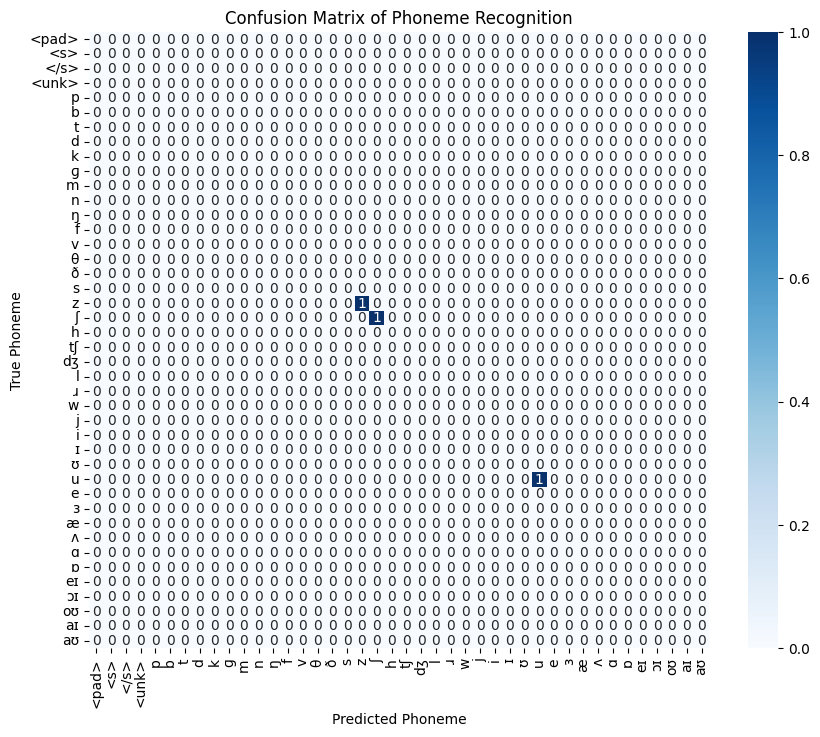

In [120]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_list[0], annot=True, fmt="d", cmap="Blues", xticklabels=english_phonemes, yticklabels=english_phonemes)
plt.xlabel('Predicted Phoneme')
plt.ylabel('True Phoneme')
plt.title('Confusion Matrix of Phoneme Recognition')
plt.show()